In [61]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import sys

## What is a $\chi^2$ distribution?

Before we talk about $\chi^2$ tests we need to discuss the eponymous distribution it is based upon. If I want to test how well a model fit some data, the question I am really asking is: what is the chance that the model only works by coincidence? How would I test this? Well, if I have $N$ data points, I could compare my model's performance, at the $N$ points, to a random distribution with $N$ degrees of freedom. 

First, I need to decide what to compare. The simplest case is just the "distance" between the model and the data, i.e. $\propto (E - O)^2$, where $O$ is the data value and $E$ the predicted value. I don't want the comparator to have physical units (to ensure it works in any scenario). Therefore, I will define the distance between my model and the data at $x$ via
\begin{equation}
d^2 = \left(\frac{E(x) - O(x)}{\delta(x)}\right)^2 \; ,
\end{equation}
this $\delta(x)$ can be chosen several ways to produce different tests. If we know the uncertainties on our measurements $O$ then $\delta = \delta O$, otherwise we can just use either $O$ or $E$ (I prefer using $O$). 

This isn't quite enough yet. How do I deal with multiple data points? I can just sum them, of course! This now defines our $\chi^2$ value
\begin{equation}
\chi^2 = \sum_i^N \left(\frac{E(x_i) - O(x_i)}{\delta(x_i)}\right)^2 \; .
\end{equation}

So, now I know what the comparator is, its the sum of the of N squares. Thus, my random version can be the sum of the squares of N randomly generated numbers. The distribution for this is the $\chi^2$ distribution with $N$ degrees of freedom. There's a caveat though, $\chi^2$ is a distribution for $N$ **independent** random variables. This means it will only be accurate if our measurements at each data point are uncorrelated. Most of the time we can assume this, but often instruments like telescopes do have correlations. 

For instance, a gamma-ray telescope categorises photons into energy bins. This means it considers all photons in the range $E_{n}$ to $E_{n+1}$, bin $n$, as having the same energy. Instruments are never 100\% accurate, so photons can be misclassified. This means they can end up in either bin $n-1$ or $n+1$ instead of $n$. Thus the bin $n$ can become correlated with its neighbours, the correlation being defined by the accuracy of the instrument in classifying photon energies.

For now we will neglect the possibility of correlated data and merrily continue with independent data points. First, we can take a look at the $\chi^2$ distribution itself. Probability distributions have two important forms to consider: the probability density and cumulative density. The probability density (pdf) is the probability that a variable takes a value between $x$ and $x+dx$ per unit $x$. The cumulative distribution (cdf) is the probability that a variable is smaller than $x$, its thus an integral over the pdf from $-\infty$ to $x$. 

Let's generate a pdf and a cdf for $\chi^2$, we will assume that we have $N=20$ data points. To do this I need to use the scipy.stats package (imported above). scipy.stats.chi2 provides access to all of the properties I need. Note that each method requires I specify the degrees of freedom as well as the values of $\chi^2$ (remember the distribution is assigning probabilities to values of $\chi^2$). 

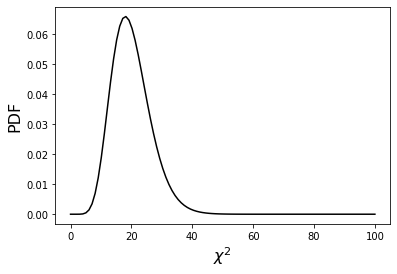

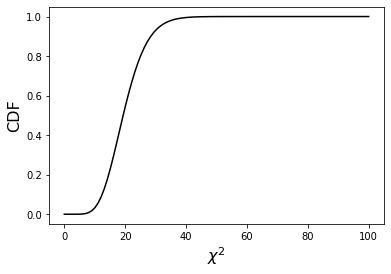

In [62]:
N = 20
x = np.linspace(0, 100,num=100)
plt.plot(x,stats.chi2.pdf(x,N),label="PDF",color="k",linestyle="-")
plt.xlabel(r"$\chi^2$",fontsize=16); plt.ylabel("PDF",fontsize=16)
plt.show()

plt.plot(x,stats.chi2.cdf(x,N),label="CDF",color="k",linestyle="-")
plt.xlabel(r"$\chi^2$",fontsize=16); plt.ylabel("CDF",fontsize=16)
plt.show()

From my pdf I can see that the distribution has two tails, or two regions where the pdf becomes vanishingly small. The cdf and pdf are only defined for $\chi^2 > 0$ which makes sense when you think about it. Additionally, as expected, the cdf rises from 0 towards 1 as $\chi^2$ gets larger. It is the probability that $\chi^2 < x$ after all. 

## How does this help us?

We know the probability that a set of random numbers will generate various sums of squares. This means we can compare the distance between our model and the data to this. What does this achieve? It tells us how likely any match between our model and data is down to pure chance. To make this comparison we will use the cdf. Sometimes people use the "survival function", or sf, which is 1 - cdf, I will discuss this later. 

The cdf is small at small values of $\chi^2$. We can interpret this as meaning that, for a very good match between $O$'s and $E$'s, the probability of the relationship being a statistical fluke is very small. In practice we use several thresholds for this. These are called confidence levels and are often referred to as $\sigma$'s, i.e. $1\sigma$ is a confidence level of $\sim 68\%$, $2\sigma$ is $95\%$, and $3\sigma$ is $99.99\%$. The percentages represent our confidence that the model is accurately predicting the data. Where do these levels come from? Simply put these are integrals over a normal distribution. The scheme is for the ith C.L. 
\begin{equation}
P_{CL}(i) = \int_{-i}^{i} dx \, \frac{\mathrm{e}^{-\frac{x^2}{2}}}{\sqrt{2\pi}} \; .
\end{equation}
The normal distribution is used here as it corresponds to a model of normally distributed errors (under assumptions like central limit theorem). You can see that, since $\sigma = 1$, we are integrating from $-i\sigma$ to $i\sigma$. The choice of mean and variance are irrelevant, these results will always be true for a normal distribution.

## Exclusion by data

Here is where we use data to say that some models must be rejected at a given confidence level, because they make the wrong predictions. Again we use the same confidence levels as before, but their meaning is subtly different. Now we are saying we reject the model because it has $95\%$ chance of over-predicting the data, for instance. This being what we would call a $2\sigma$ exclusion. Note that whether we care about under or over-predicting data depends on our scenario. For dark matter hunting, we can only place limits on models that produce more emissions than actually observed (if it were less, these models could just be hidden under the stronger signal). Thus, we only care about over-predictions by the model.  

To implement this, I will generate some fake data and a toy model

In [63]:
def modelResult(x):
    mu = 5e1
    sig = 1e1
    #artificial model I created 
    return 1e14*np.exp(-(x-mu)**2/sig**2*0.5)

def dataResult(x,y0,alpha):
    #fake data that's just a power-law
    return y0*x**alpha

I will now choose some x range to consider them over, I will choose it so the gaussian bump of the model fits into the range

In [64]:
x = np.logspace(1,2,num=20)
model = modelResult(x)
data = dataResult(x,1e-10,-1.5)

Now we are at the point you would be in reality. You have some data points and model predictions at those data points. In dark matter hunting we have a free parameter $\langle \sigma V \rangle$, so we must consider the model results for a range of cross-sections. By doing so, we hope to exclude values of the cross-section that over-predict the data. Note that my model function here is like dark matters (assumes $\langle \sigma V \rangle = 1$ cm $^3$ s $^{-1}$). 

In [65]:
sigV = np.logspace(-3,3,num=3000)*1e-26
model = np.tensordot(sigV,model,axes=0)

What I have done here is generated a 2D array where each element is every possible combination of a sigV value times a model value. I will need to ensure my data is the same shape array (to be able to compare them). However, data does not vary with sigV, it is fixed. Thus, I will do the following

In [66]:
data = np.tensordot(np.ones_like(sigV),data,axes=0)

Which generates a 2D array filled with copies of data array. Now I can find their $\chi^2$ values

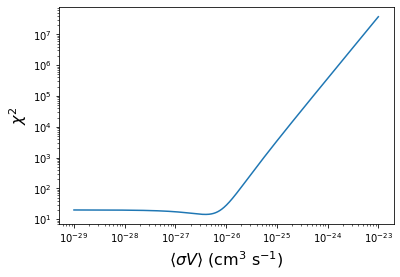

In [67]:
def chiSquare(model,data,axis=-1,dataUncert=None,alpha=2):
    """
    model and data are the predicted and observed values respectively
    This method assumes data and model are sampled at the same values of the independent variable
    """
    if dataUncert is None:
        dataUncert = data #modify the test if we don't know the uncertainties on the data
    if dataUncert.shape != data.shape or model.shape != data.shape:
        print("chiSquare error: model, data, and dataUncert (if specified) must be the same shape!")
        sys.exit(2)
    return np.sum((model-data)**alpha/dataUncert**alpha,axis=axis) #we always sum over the data points so I need to specify which axis this corresponds to

chi2 = chiSquare(model,data,axis=-1)

plt.plot(sigV,chi2)
plt.ylabel(r"$\chi^2$",fontsize=16)
plt.xlabel(r"$\langle \sigma V\rangle$ (cm$^3$ s$^{-1}$)",fontsize=16)
plt.yscale("log");plt.xscale("log")
plt.show()

Note my use of the argument "axis=-1", this is because I multiplied data by a set of ones on the left. Thus, the data axis is the last axis (or -1). We can see our distribution has a minimum. This we could use to find a best-fit dark matter $\langle \sigma V \rangle$. However, I want to exclude over predicting models. Let's begin by normalising over $\chi^2$ by subtracting off the minimum value. This is done because now we are performing a so-called "likelihood ratio test". Where our likelihood is
\begin{equation}
\mathcal{L}_i = \mathrm{e}^{-\chi_i^2/2} \; ,
\end{equation}
for model $i$ and our ratio test is done via
\begin{equation}
2\ln{\left(\frac{\mathcal{L}_i}{\mathcal{L}_{\mathrm{max}}}\right)} = \chi^2_i - \chi^2_{\mathrm{min}} \; .
\end{equation}

How do we know what points are excluded though? Let's use a 95\% confidence exclusion. Now, any model with a $\chi^2$ that corresponds to the cdf being 0.95 or greater has a 95\% chance of not being a good explanation of the data. However, this will include both under and over-predicting models (as $\chi^2$ is a square of the distance between data and model). To exclude the under predicting models we will look for values of $\langle \sigma V\rangle$ that have $E(x_i) > O(x_i)$ for any of the data points $x_i$. Then we will only examine the $\chi^2$ values for the models that survive this test.

(3000,)


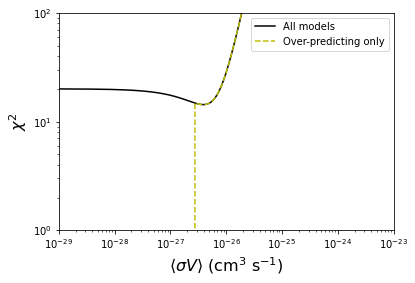

In [68]:
chi = (model-data)/data #2D array (len(sigV) by len(data))
chi2Over = np.zeros_like(sigV)
for i in range(len(sigV)):
        if np.any(chi[i]>0.0): #is E > O for any data points for ith sigV value
            chi2Over[i] = chi2[i] 
print(chi2Over.shape)
plt.plot(sigV,chi2,color="k",label="All models")
plt.plot(sigV,chi2Over,color="y",linestyle="--",label="Over-predicting only")
plt.xscale("log");plt.yscale("log")
plt.ylim([1e0,1e2])
plt.xlim([sigV[0],sigV[-1]])
plt.ylabel(r"$\chi^2$",fontsize=16)
plt.xlabel(r"$\langle \sigma V\rangle$ (cm$^3$ s$^{-1}$)",fontsize=16)
plt.legend()
plt.show()

The plot tells us that $\langle \sigma V \rangle \gtrsim 3\times 10^{-27}$ cm $^3$ s $^{-1}$ result in over-predicting models. What we can now do is determine how badly they over-predict the data. For this we will need to determine the cdf for these $\chi^2$ values. First, we need to normalise $\chi^2$. Then we will feed this into the cdf and ask which is the smallest $\langle \sigma V \rangle$ that yields a cdf $> 0.95$. Note we need to use the original minimum from chi2, not chi2Over. We will plot a comparison of 2*data (roughly like a 95\% exclusion) with this model prediction just as a sanity check. 

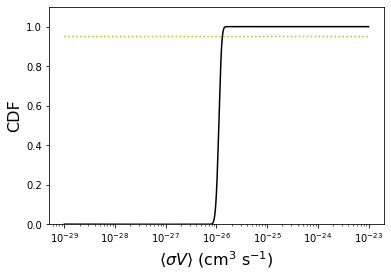

Values of sigV > 1.31e-26 cm^3 s^-1 are excluded at a 95% confidence level


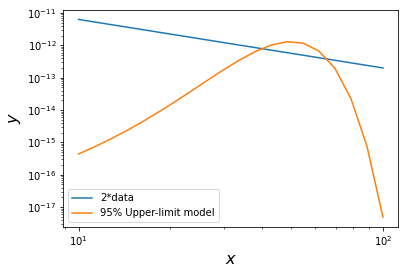

In [69]:
chiDiffOver = chi2Over - np.min(chi2)
chiDiff = chi2 - np.min(chi2)
cdfOver = stats.chi2.cdf(chiDiffOver,len(x))
cdf = stats.chi2.cdf(chiDiff,len(x))
plt.plot(sigV,cdf,color="k")
plt.xscale("log")
plt.plot(sigV,np.ones_like(sigV)*0.95,linestyle=":",color="y")
plt.ylim([0,1.1])
plt.ylabel("CDF",fontsize=16)
plt.xlabel(r"$\langle \sigma V\rangle$ (cm$^3$ s$^{-1}$)",fontsize=16)
plt.show()

upperLim = np.min(sigV[cdfOver>=0.95])

print("Values of sigV > {:.2e} cm^3 s^-1 are excluded at a 95% confidence level".format(upperLim))


plt.plot(x,dataResult(x,1e-10,-1.5)*2,label="2*data")
plt.plot(x,modelResult(x)*upperLim,label="95% Upper-limit model")
plt.ylabel(r"$y$",fontsize=16)
plt.xlabel(r"$x$",fontsize=16)
plt.yscale("log");plt.xscale("log")
plt.legend()
plt.show()

What we see is a small selection of negative $\chi$ values are excluded at a 95\% confidence interval (above yellow dotted line). We found the smallest such value using np.min(sigVNeg[cdf>=0.95]) to select the minimum sigV that has a cdf value above 0.95. Finally, our sanity check is good, as our upper-limit model just exceeds 2*data. 

## Incorporating dark matter mass

The above example works for a fixed dark matter mass. I will now modify the model to include a fake version of the effect of varying the mass. Due to my choice of model, I will need to expand the x range as well.

In [70]:
def modelResult(x,m):
    mu = 5e1*m/10.0
    sig = 1e1*m/10
    #artificial model I created 
    return 1e14*np.exp(-(x-mu)**2/sig**2*0.5)/(m/10)**2

def dataResult(x,y0,alpha):
    #fake data that's just a power-law
    return y0*x**alpha

Now what I aim to do is find a sigV limit for a set of masses. I will choose a few, logarithmically spaced, and run a loop over them

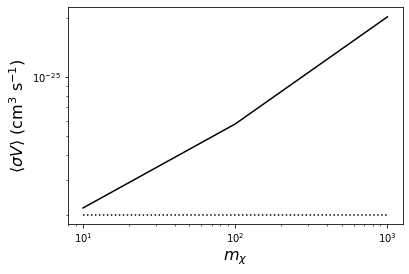

In [72]:
mSet = np.array([1e1,1e2,1e3])
upperLims = []

for m in mSet:
    x = np.logspace(1,4,num=20)
    model = modelResult(x,m)
    data = dataResult(x,1e-10,-1.5)
    sigV = np.logspace(-3,5,num=3000)*1e-26
    model = np.tensordot(sigV,model,axes=0)
    data = np.tensordot(np.ones_like(sigV),data,axes=0)
    chi2 = chiSquare(model,data,axis=-1,alpha=2)
    chi = (model-data)/data #2D array (len(sigV) by len(data))
    chi2Over = np.zeros_like(sigV)
    for i in range(len(sigV)):
        if np.any(chi[i]>0.0): #is E > O for any data points for ith sigV value
            chi2Over[i] = chi2[i] 
    chiDiff = chi2Over - np.min(chi2)
    cdf = stats.chi2.cdf(chiDiff,len(x))
    upperLims.append(np.min(sigV[cdf>=0.95]))

plt.plot(mSet,upperLims,linestyle="-",color="k")
plt.plot(mSet,np.ones_like(mSet)*2e-26,linestyle=":",color="k")
plt.yscale("log");plt.xscale("log")
plt.ylabel(r"$\langle \sigma V\rangle$ (cm$^3$ s$^{-1}$)",fontsize=16)
plt.xlabel(r"$m_\chi$",fontsize=16)
plt.show()

My final plot is then the exclusion curve, models above the solid line are excluded at 95% C.L. The dotted line is the thermal relic cross-section (the value needed to produce the amount of observed dark matter )